# Lets make an interactive web application from scratch

First we have to import some dependencies 

In [1]:
import sys
sys.path.append('..')
import urbanpy as up
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shapely
from tqdm.auto import tqdm

In [2]:
tqdm.pandas()

/home/claudio/Documents/urbanpy/.env/lib/python3.7/site-packages/tqdm/std.py:706: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## Downloading urban data

This notebook is going to use the Lima's metropolitan area as an example. now we are going to download Lima province & Callao province limits and merge them to obtain Lima's Metropolitan area.

In [3]:
manta = up.download.nominatim_osm('Manta, Ecuador')

<AxesSubplot:>

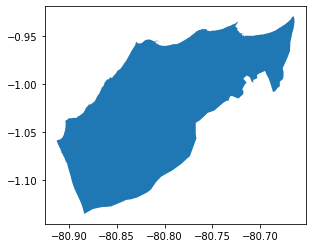

In [4]:
manta.plot()

It is useful to have a uniform spatial unit in order to apply algorithms and visualize differents cities data. UrbanPy lets your easily leverage all the power of Uber H3 package to partition the city in uniform hexagons.

In [5]:
hex_manta = up.geom.gen_hexagons(resolution=9, city=manta)

In [6]:
hex_manta.head()

,hex,geometry
0,898f2e0f363ffff,"POLYGON ((-80.83145 -0.95936, -80.83260 -0.960..."
1,898f2e76447ffff,"POLYGON ((-80.78376 -1.06608, -80.78492 -1.067..."
2,898f2e0ce27ffff,"POLYGON ((-80.76465 -1.02603, -80.76581 -1.027..."
3,898f2e76643ffff,"POLYGON ((-80.80823 -1.07344, -80.80939 -1.075..."
4,898f2e0c37bffff,"POLYGON ((-80.79830 -1.00870, -80.79945 -1.010..."


In [7]:
hex_manta.shape

(2416, 2)

<AxesSubplot:>

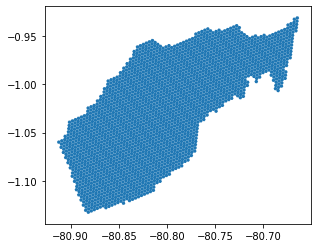

In [8]:
hex_manta.plot()

### Downloading high resolution population data

Using the `download.hdx_fb_population` function you can download high resolution population data, please be patient this may take a while ...

In [9]:
ecu_elderly_pop = up.download.hdx_fb_population('ecuador', 'elderly')

In [10]:
manta_elderly_pop = up.geom.filter_population(ecu_elderly_pop, manta)

In [11]:
manta_elderly_pop.head()

,latitude,longitude,population,geometry
123183,-0.967083,-80.666528,0.395339,POINT (-80.66653 -0.96708)
123194,-0.972361,-80.670139,0.395339,POINT (-80.67014 -0.97236)
123196,-0.959583,-80.667083,0.395339,POINT (-80.66708 -0.95958)
123198,-0.965694,-80.667361,0.395339,POINT (-80.66736 -0.96569)
123206,-0.965139,-80.664583,0.395339,POINT (-80.66458 -0.96514)


### Unify data layers

Lets get the population per hexagon

In [12]:
hex_manta_gdf = up.geom.merge_shape_hex(hex_manta, manta_elderly_pop, how='inner', op='intersects', agg={'population': 'sum'})

In [13]:
hex_manta_gdf.head()

,hex,geometry,population
0,898f2e0f363ffff,"POLYGON ((-80.83145 -0.95936, -80.83260 -0.960...",0.837724
1,898f2e76447ffff,"POLYGON ((-80.78376 -1.06608, -80.78492 -1.067...",NaN
2,898f2e0ce27ffff,"POLYGON ((-80.76465 -1.02603, -80.76581 -1.027...",NaN
3,898f2e76643ffff,"POLYGON ((-80.80823 -1.07344, -80.80939 -1.075...",NaN
4,898f2e0c37bffff,"POLYGON ((-80.79830 -1.00870, -80.79945 -1.010...",NaN


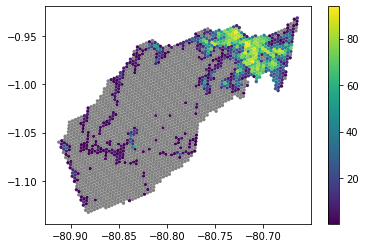

In [14]:
hex_manta_gdf.plot(column='population', legend=True, missing_kwds={'color': 'grey'})
plt.show()

**Validation**: The difference between original population total and downscaled population total must be a small number

In [15]:
(manta_elderly_pop['population'].sum(), hex_manta_gdf['population'].round(0).sum(), 
 manta_elderly_pop['population'].sum() - hex_manta_gdf['population'].round(0).sum())

(22962.965394, 19966.0, 2996.965393999999)

## Downloading Points of Interest (PoI) data

### Health facilities

In [16]:
health_facilities = up.download.overpass_pois(bounds=manta.total_bounds, facilities='health')

In [17]:
health_facilities.head()

,type,id,lat,lon,tags,geometry,poi_type
0,node,367826732,-0.944024,-80.733939,"{'amenity': 'pharmacy', 'name': 'Fybeca'}",POINT (-80.73394 -0.94402),pharmacy
1,node,367830065,-0.953998,-80.741467,"{'amenity': 'hospital', 'name': 'Clínica del S...",POINT (-80.74147 -0.95400),hospital
2,node,367830072,-0.953488,-80.740739,"{'amenity': 'hospital', 'name': 'Clínica Cente...",POINT (-80.74074 -0.95349),hospital
3,node,3206491590,-1.040708,-80.665107,"{'amenity': 'hospital', 'name': 'Clínica Monte...",POINT (-80.66511 -1.04071),hospital
4,node,4122103989,-0.970592,-80.702927,"{'addr:street': 'Avenida 4 de Noviembre', 'ame...",POINT (-80.70293 -0.97059),clinic


In [18]:
health_facilities['poi_type'].value_counts()

pharmacy    39
clinic      10
hospital    10
doctors      3
dentist      1
Name: poi_type, dtype: int64

### Measuring accesibility

#### Accesibility to hospital and clinics

 To find the nearest food facility to each hexagon we are going to use a neighborhood search algorithm (lower precision but significant time savings)

In [19]:
clinics_and_hospitals = health_facilities[health_facilities['poi_type'].isin(['clinic', 'hospital'])]

In [20]:
# Get Hexagon centroid latitude and longitude
hex_manta_gdf['lon'] = hex_manta_gdf.geometry.centroid.x
hex_manta_gdf['lat'] = hex_manta_gdf.geometry.centroid.y

/home/claudio/Documents/urbanpy/.env/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  
/home/claudio/Documents/urbanpy/.env/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
# Get distance and indexes from nearest points 
dist, ind = up.utils.nn_search(
    tree_features = clinics_and_hospitals[['lat', 'lon']].values, # Point of Interest
    query_features = hex_manta_gdf[['lat', 'lon']].values, # Hexagon
    metric='manhattan' # Distance metric
)

In [22]:
# Add nearest health facility index to the hexagon gdf
hex_manta_gdf['nearest_health_facility_ix'] = ind

Now we are going to find the route distance and duration using an OSRM local server

In [23]:
# start server
up.routing.start_osrm_server('ecuador', 'south-america', 'foot')

Starting server ...
Server was started succesfully


First we are going to find the route distance and duration for one hexagon

In [24]:
origin = hex_manta_gdf.geometry.centroid[0] # Origin Point

/home/claudio/Documents/urbanpy/.env/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.


In [25]:
destination = clinics_and_hospitals.iloc[hex_manta_gdf['nearest_health_facility_ix'][0]].geometry # Destination Point

In [26]:
# Distance (meters), Duration (seconds)
up.routing.osrm_route(origin, destination)

(4909, 3534.5)

Now we apply this function to all the origin points (hexagons) and their corresponding destination

In [27]:
# Distancia y duración del viaje a pie
dist_dur = hex_manta_gdf.progress_apply(
    lambda row: up.routing.osrm_route(
        origin=row.geometry.centroid, 
        destination=clinics_and_hospitals.iloc[row['nearest_health_facility_ix']].geometry,
    ),
    result_type='expand', axis=1
)

In [28]:
dist_dur

,0,1
0,4909.0,3534.5
1,NaN,NaN
2,10560.1,7609.3
3,NaN,NaN
4,NaN,NaN
...,...,...
2411,NaN,NaN
2412,4315.6,3112.9
2413,9756.0,7023.7
2414,12593.1,9066.4


In [29]:
hex_manta_gdf['distance_health_facility'] =  dist_dur[0] / 1000 # meters to km

In [30]:
hex_manta_gdf['duration_health_facility'] =  dist_dur[1] / 60 # seconds to minutes

Visualize results

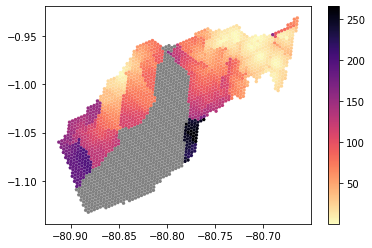

In [31]:
hex_manta_gdf.plot(column='duration_health_facility', cmap='magma_r', legend=True, missing_kwds={'color': 'grey'})
plt.show()

In [32]:
up.routing.stop_osrm_server('ecuador', 'south-america', 'foot')

Server was stoped succesfully


# Using Dash to create an interactive webapp

Import Dash dependencies

In [33]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output

In this example we are using JupyterDash to show our webapp within jupyter lab or a notebook.

In [34]:
from jupyter_dash import JupyterDash

In [35]:
app = JupyterDash(name='UrbanPy Dashboard')

In [36]:
VARIABLE_OPTIONS = [
    {'label': 'Duración del viaje', 'value': 'duration_health_facility'},
    {'label': 'Población mayor de 60', 'value': 'population'}
]

In [37]:
app.layout = html.Div([
    html.H3('Analisis de Acceso a Comida para Población Mayor en Manta, Ecuador'),
    dcc.Dropdown(id='variable', value='population', options=VARIABLE_OPTIONS),
    dcc.Graph(id="map")
])

In [38]:
@app.callback(Output('map', 'figure'),
              [Input('variable', 'value')])
def update_map(var):
    return up.plotting.choropleth_map(gdf=hex_manta_gdf, color_column=var)

In [39]:
app.run_server(mode='inline')

Thanks for viewing this example notebook. You can find the urbanpy documentation [here](https://ingenieriaup.github.io/urbanpy/).

Useful resources:

1. [Dash Getting Started](https://dash.plotly.com/layout)
2. [Dash Make your Webapp public available](https://dash.plotly.com/deployment)